## Useful Modules

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import time
from tqdm import tqdm

from matplotlib import pyplot as plt
from models import lnn, cnn, resnet

%load_ext autoreload
%autoreload 2

In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]
)

## Training and Testing Utils

In [3]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=10, device='cpu', model_name='model', dataset_name='dataset'):
    model.to(device)

    train_loss_history = []
    train_accuracy_history = []
    
    valid_loss_history = []
    valid_accuracy_history = []
    
    best_iter = 0
    best_valid_loss = float('inf')
    best_valid_accuracy = 0.0
    best_model = None

    start_time = time.time()

    for epoch in range(epochs):
        model.train()

        train_loss, train_corrects = 0.0, 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            predicted = outputs.argmax(dim=1)
            train_corrects += (predicted == labels).sum().item()
    
        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = train_corrects / len(train_loader.dataset)

        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        
        model.eval()
        
        valid_loss, valid_corrects = 0.0, 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(valid_loader, desc=f'Epoch {epoch+1}/{epochs}'):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)

                predicted = outputs.argmax(dim=1)
                valid_corrects += (predicted == labels).sum().item()
        
        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_accuracy = valid_corrects / len(valid_loader.dataset)
        
        if valid_accuracy > best_valid_accuracy:
            best_iter = epoch + 1
            best_valid_loss = valid_loss
            best_valid_accuracy = valid_accuracy
            best_model = model.state_dict()
        
        valid_loss_history.append(valid_loss)
        valid_accuracy_history.append(valid_accuracy)
        
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')
    
    end_time = time.time()

    print(f'Total training time: {end_time - start_time:.2f} seconds.')
    
    torch.save(best_model, f'weights/{dataset_name}_{model_name}_best.pth')
    
    print(f'Best model at epoch {best_iter} with valid loss: {best_valid_loss:.4f}, valid accuracy: {best_valid_accuracy:.4f}')
    
    torch.save(model.state_dict(), f'weights/{dataset_name}_{model_name}_last.pth')

    return train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history

In [4]:
def test_model(model, test_loader, criterion, device='cpu'):
    model.to(device)
    model.eval()
    
    test_loss, test_corrects = 0.0, 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * inputs.size(0)
            
            predicted = outputs.argmax(dim=1)
            test_corrects += (predicted == labels).sum().item()
        
    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = test_corrects / len(test_loader.dataset)
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%')
    
    return test_loss, test_accuracy

## MNIST Digit Classification

In [5]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_set, valid_set = torch.utils.data.random_split(train_dataset, [50000, 10000])
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

### Linear Neural Network

In [7]:
lnn_model = lnn.LNN(28 * 28, num_classes=10)

num_params = sum([p.numel() for p in lnn_model.parameters()])
print("Number of parameters: ", num_params)

Number of parameters:  15501322


In [8]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lnn_model.parameters(), lr=0.00001)

train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history = train_model(lnn_model, train_loader, valid_loader, criterion, optimizer, epochs=30, device='cuda', model_name='lnn', dataset_name='mnist')

Epoch 1/30: 100%|██████████| 157/157 [00:00<00:00, 327.41it/s]


Train Loss: 0.7478, Train Accuracy: 0.8101
Valid Loss: 0.3541, Valid Accuracy: 0.8972


Epoch 2/30: 100%|██████████| 157/157 [00:00<00:00, 287.34it/s]


Train Loss: 0.3154, Train Accuracy: 0.9066
Valid Loss: 0.2833, Valid Accuracy: 0.9195


Epoch 3/30: 100%|██████████| 157/157 [00:00<00:00, 291.62it/s]


Train Loss: 0.2542, Train Accuracy: 0.9245
Valid Loss: 0.2395, Valid Accuracy: 0.9294


Epoch 4/30: 100%|██████████| 157/157 [00:00<00:00, 277.36it/s]


Train Loss: 0.2155, Train Accuracy: 0.9358
Valid Loss: 0.2120, Valid Accuracy: 0.9376


Epoch 5/30: 100%|██████████| 157/157 [00:00<00:00, 295.25it/s]


Train Loss: 0.1851, Train Accuracy: 0.9446
Valid Loss: 0.1838, Valid Accuracy: 0.9457


Epoch 6/30: 100%|██████████| 157/157 [00:00<00:00, 295.74it/s]


Train Loss: 0.1626, Train Accuracy: 0.9517
Valid Loss: 0.1636, Valid Accuracy: 0.9519


Epoch 7/30: 100%|██████████| 157/157 [00:00<00:00, 275.35it/s]


Train Loss: 0.1421, Train Accuracy: 0.9576
Valid Loss: 0.1534, Valid Accuracy: 0.9550


Epoch 8/30: 100%|██████████| 157/157 [00:00<00:00, 309.08it/s]


Train Loss: 0.1268, Train Accuracy: 0.9622
Valid Loss: 0.1407, Valid Accuracy: 0.9595


Epoch 9/30: 100%|██████████| 157/157 [00:00<00:00, 298.94it/s]


Train Loss: 0.1139, Train Accuracy: 0.9654
Valid Loss: 0.1331, Valid Accuracy: 0.9611


Epoch 10/30: 100%|██████████| 157/157 [00:00<00:00, 323.69it/s]


Train Loss: 0.1026, Train Accuracy: 0.9693
Valid Loss: 0.1216, Valid Accuracy: 0.9643


Epoch 11/30: 100%|██████████| 157/157 [00:00<00:00, 319.58it/s]


Train Loss: 0.0922, Train Accuracy: 0.9723
Valid Loss: 0.1162, Valid Accuracy: 0.9653


Epoch 12/30: 100%|██████████| 157/157 [00:00<00:00, 311.00it/s]


Train Loss: 0.0836, Train Accuracy: 0.9755
Valid Loss: 0.1213, Valid Accuracy: 0.9633


Epoch 13/30: 100%|██████████| 157/157 [00:00<00:00, 304.39it/s]


Train Loss: 0.0765, Train Accuracy: 0.9769
Valid Loss: 0.1057, Valid Accuracy: 0.9691


Epoch 14/30: 100%|██████████| 157/157 [00:00<00:00, 295.68it/s]


Train Loss: 0.0688, Train Accuracy: 0.9793
Valid Loss: 0.1005, Valid Accuracy: 0.9693


Epoch 15/30: 100%|██████████| 157/157 [00:00<00:00, 303.91it/s]


Train Loss: 0.0637, Train Accuracy: 0.9812
Valid Loss: 0.0952, Valid Accuracy: 0.9707


Epoch 16/30: 100%|██████████| 157/157 [00:00<00:00, 298.64it/s]


Train Loss: 0.0569, Train Accuracy: 0.9833
Valid Loss: 0.1085, Valid Accuracy: 0.9676


Epoch 17/30: 100%|██████████| 157/157 [00:00<00:00, 294.64it/s]


Train Loss: 0.0527, Train Accuracy: 0.9840
Valid Loss: 0.0939, Valid Accuracy: 0.9704


Epoch 18/30: 100%|██████████| 157/157 [00:00<00:00, 297.99it/s]


Train Loss: 0.0472, Train Accuracy: 0.9861
Valid Loss: 0.0903, Valid Accuracy: 0.9720


Epoch 19/30: 100%|██████████| 157/157 [00:00<00:00, 294.96it/s]


Train Loss: 0.0424, Train Accuracy: 0.9882
Valid Loss: 0.0913, Valid Accuracy: 0.9722


Epoch 20/30: 100%|██████████| 157/157 [00:00<00:00, 286.83it/s]


Train Loss: 0.0390, Train Accuracy: 0.9887
Valid Loss: 0.0856, Valid Accuracy: 0.9738


Epoch 21/30: 100%|██████████| 157/157 [00:00<00:00, 313.98it/s]


Train Loss: 0.0348, Train Accuracy: 0.9898
Valid Loss: 0.0872, Valid Accuracy: 0.9729


Epoch 22/30: 100%|██████████| 157/157 [00:00<00:00, 303.09it/s]


Train Loss: 0.0314, Train Accuracy: 0.9911
Valid Loss: 0.0811, Valid Accuracy: 0.9759


Epoch 23/30: 100%|██████████| 157/157 [00:00<00:00, 328.99it/s]


Train Loss: 0.0279, Train Accuracy: 0.9928
Valid Loss: 0.0795, Valid Accuracy: 0.9767


Epoch 24/30: 100%|██████████| 157/157 [00:00<00:00, 320.09it/s]


Train Loss: 0.0256, Train Accuracy: 0.9932
Valid Loss: 0.0837, Valid Accuracy: 0.9749


Epoch 25/30: 100%|██████████| 157/157 [00:00<00:00, 298.06it/s]


Train Loss: 0.0228, Train Accuracy: 0.9939
Valid Loss: 0.0839, Valid Accuracy: 0.9751


Epoch 26/30: 100%|██████████| 157/157 [00:00<00:00, 307.38it/s]


Train Loss: 0.0206, Train Accuracy: 0.9945
Valid Loss: 0.0829, Valid Accuracy: 0.9768


Epoch 27/30: 100%|██████████| 157/157 [00:00<00:00, 305.78it/s]


Train Loss: 0.0185, Train Accuracy: 0.9954
Valid Loss: 0.0781, Valid Accuracy: 0.9772


Epoch 28/30: 100%|██████████| 157/157 [00:00<00:00, 299.28it/s]


Train Loss: 0.0176, Train Accuracy: 0.9955
Valid Loss: 0.0892, Valid Accuracy: 0.9758


Epoch 29/30: 100%|██████████| 157/157 [00:00<00:00, 307.57it/s]


Train Loss: 0.0144, Train Accuracy: 0.9967
Valid Loss: 0.0816, Valid Accuracy: 0.9761


Epoch 30/30: 100%|██████████| 157/157 [00:00<00:00, 322.86it/s]


Train Loss: 0.0127, Train Accuracy: 0.9973
Valid Loss: 0.0827, Valid Accuracy: 0.9766
Total training time: 185.40 seconds.
Best model at epoch 27 with valid loss: 0.0781, valid accuracy: 0.9772


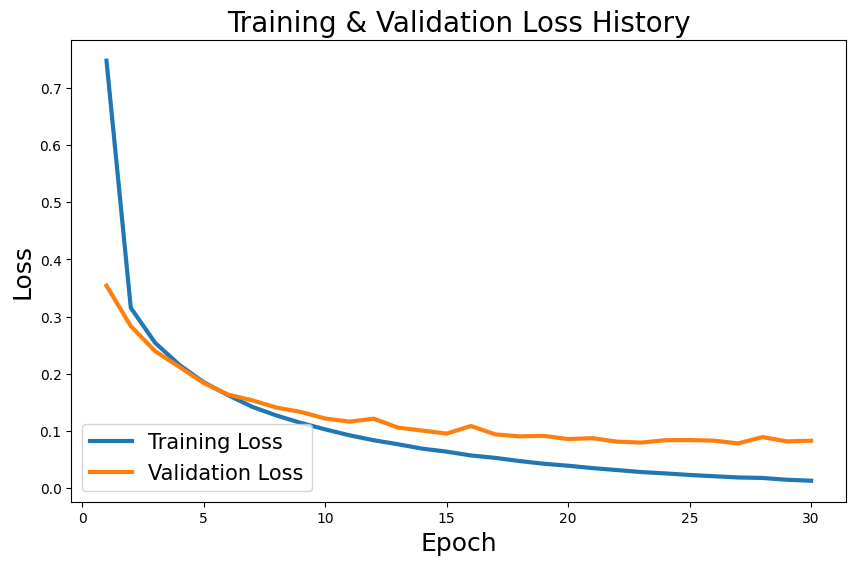

In [9]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Training Loss', linewidth=3)
plt.plot(range(1, len(valid_loss_history) + 1), valid_loss_history, label='Validation Loss', linewidth=3)

plt.title('Training & Validation Loss History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='lower left', fontsize=15)

plt.savefig('figures/mnist_lnn_loss_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

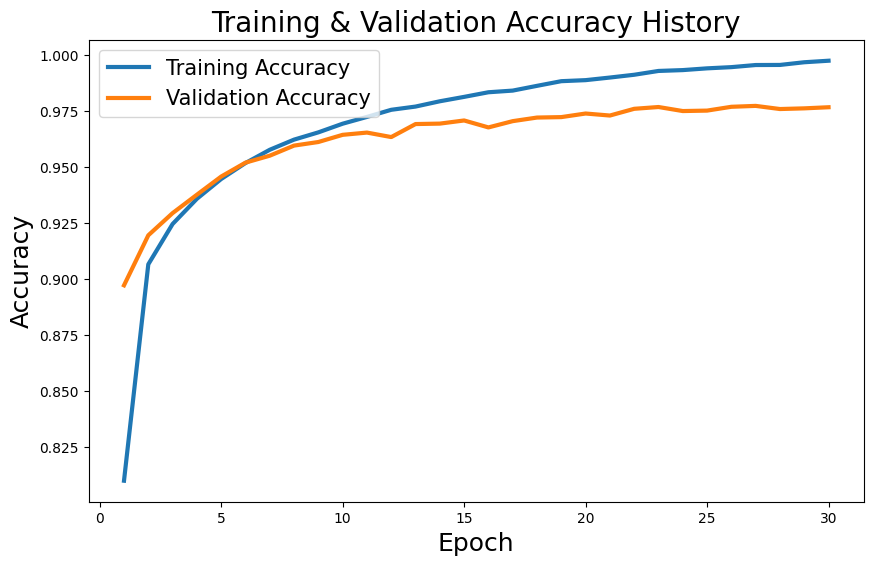

In [10]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_accuracy_history) + 1), train_accuracy_history, label='Training Accuracy', linewidth=3)
plt.plot(range(1, len(valid_accuracy_history) + 1), valid_accuracy_history, label='Validation Accuracy', linewidth=3)

plt.title('Training & Validation Accuracy History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend(loc='upper left', fontsize=15)

plt.savefig('figures/mnist_lnn_accuracy_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

In [11]:
test_loss, test_accuracy = test_model(lnn_model, test_loader, criterion, device='cuda')

Test Loss: 0.0752, Test Accuracy: 0.9779%


### Convolutional Neural Network

In [12]:
cnn_model = cnn.CNN(1, num_classes=10, input_size=28)

num_params = sum([p.numel() for p in cnn_model.parameters()])
print("Number of parameters: ", num_params)

Number of parameters:  659250


In [13]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.00001)

train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history = train_model(cnn_model, train_loader, valid_loader, criterion, optimizer, epochs=20, device='cuda', model_name='cnn', dataset_name='mnist')

Epoch 1/20:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1/20: 100%|██████████| 157/157 [00:00<00:00, 309.67it/s]


Train Loss: 1.0590, Train Accuracy: 0.7953
Valid Loss: 0.3516, Valid Accuracy: 0.9338


Epoch 2/20: 100%|██████████| 157/157 [00:00<00:00, 322.27it/s]


Train Loss: 0.2346, Train Accuracy: 0.9504
Valid Loss: 0.1673, Valid Accuracy: 0.9603


Epoch 3/20: 100%|██████████| 157/157 [00:00<00:00, 326.78it/s]


Train Loss: 0.1352, Train Accuracy: 0.9658
Valid Loss: 0.1132, Valid Accuracy: 0.9706


Epoch 4/20: 100%|██████████| 157/157 [00:00<00:00, 332.36it/s]


Train Loss: 0.0973, Train Accuracy: 0.9745
Valid Loss: 0.0871, Valid Accuracy: 0.9755


Epoch 5/20: 100%|██████████| 157/157 [00:00<00:00, 308.19it/s]


Train Loss: 0.0766, Train Accuracy: 0.9791
Valid Loss: 0.0726, Valid Accuracy: 0.9797


Epoch 6/20: 100%|██████████| 157/157 [00:00<00:00, 326.33it/s]


Train Loss: 0.0637, Train Accuracy: 0.9827
Valid Loss: 0.0632, Valid Accuracy: 0.9823


Epoch 7/20: 100%|██████████| 157/157 [00:00<00:00, 306.00it/s]


Train Loss: 0.0547, Train Accuracy: 0.9849
Valid Loss: 0.0571, Valid Accuracy: 0.9827


Epoch 8/20: 100%|██████████| 157/157 [00:00<00:00, 280.27it/s]


Train Loss: 0.0475, Train Accuracy: 0.9874
Valid Loss: 0.0511, Valid Accuracy: 0.9848


Epoch 9/20: 100%|██████████| 157/157 [00:00<00:00, 297.76it/s]


Train Loss: 0.0420, Train Accuracy: 0.9887
Valid Loss: 0.0473, Valid Accuracy: 0.9859


Epoch 10/20: 100%|██████████| 157/157 [00:00<00:00, 325.25it/s]


Train Loss: 0.0376, Train Accuracy: 0.9900
Valid Loss: 0.0440, Valid Accuracy: 0.9866


Epoch 11/20: 100%|██████████| 157/157 [00:00<00:00, 297.77it/s]


Train Loss: 0.0332, Train Accuracy: 0.9912
Valid Loss: 0.0419, Valid Accuracy: 0.9874


Epoch 12/20: 100%|██████████| 157/157 [00:00<00:00, 334.36it/s]


Train Loss: 0.0299, Train Accuracy: 0.9924
Valid Loss: 0.0407, Valid Accuracy: 0.9884


Epoch 13/20: 100%|██████████| 157/157 [00:00<00:00, 319.97it/s]


Train Loss: 0.0270, Train Accuracy: 0.9930
Valid Loss: 0.0388, Valid Accuracy: 0.9890


Epoch 14/20: 100%|██████████| 157/157 [00:00<00:00, 303.74it/s]


Train Loss: 0.0243, Train Accuracy: 0.9938
Valid Loss: 0.0371, Valid Accuracy: 0.9895


Epoch 15/20: 100%|██████████| 157/157 [00:00<00:00, 341.75it/s]


Train Loss: 0.0220, Train Accuracy: 0.9946
Valid Loss: 0.0370, Valid Accuracy: 0.9889


Epoch 16/20: 100%|██████████| 157/157 [00:00<00:00, 308.89it/s]


Train Loss: 0.0197, Train Accuracy: 0.9955
Valid Loss: 0.0352, Valid Accuracy: 0.9900


Epoch 17/20: 100%|██████████| 157/157 [00:00<00:00, 307.15it/s]


Train Loss: 0.0174, Train Accuracy: 0.9961
Valid Loss: 0.0344, Valid Accuracy: 0.9906


Epoch 18/20: 100%|██████████| 157/157 [00:00<00:00, 312.14it/s]


Train Loss: 0.0159, Train Accuracy: 0.9964
Valid Loss: 0.0336, Valid Accuracy: 0.9903


Epoch 19/20: 100%|██████████| 157/157 [00:00<00:00, 331.01it/s]


Train Loss: 0.0143, Train Accuracy: 0.9974
Valid Loss: 0.0328, Valid Accuracy: 0.9903


Epoch 20/20: 100%|██████████| 157/157 [00:00<00:00, 323.06it/s]

Train Loss: 0.0129, Train Accuracy: 0.9977
Valid Loss: 0.0336, Valid Accuracy: 0.9904
Total training time: 71.19 seconds.
Best model at epoch 17 with valid loss: 0.0344, valid accuracy: 0.9906


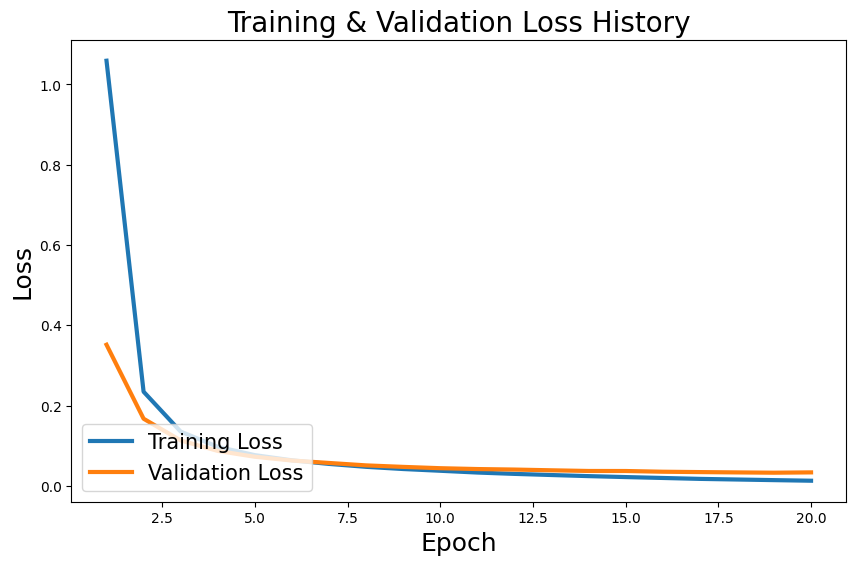

In [14]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Training Loss', linewidth=3)
plt.plot(range(1, len(valid_loss_history) + 1), valid_loss_history, label='Validation Loss', linewidth=3)

plt.title('Training & Validation Loss History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='lower left', fontsize=15)

plt.savefig('figures/mnist_cnn_loss_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

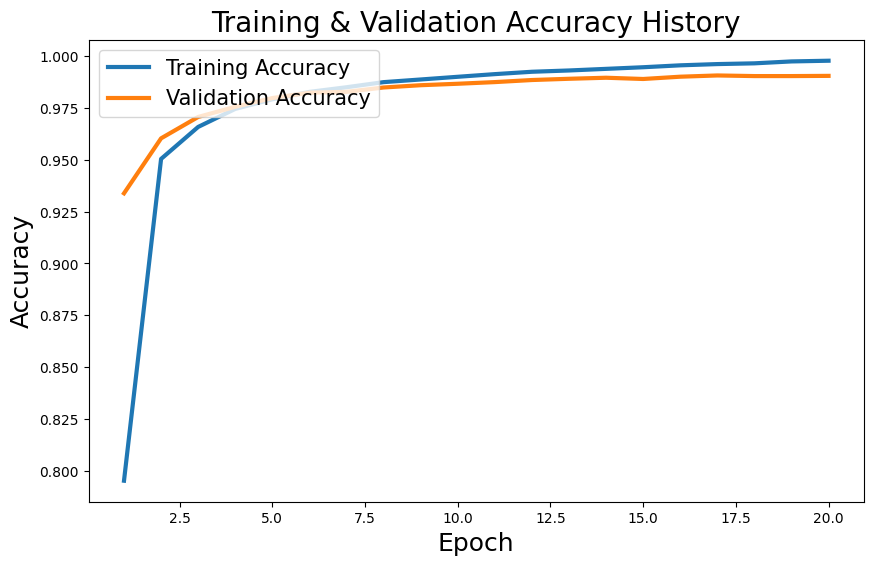

In [15]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_accuracy_history) + 1), train_accuracy_history, label='Training Accuracy', linewidth=3)
plt.plot(range(1, len(valid_accuracy_history) + 1), valid_accuracy_history, label='Validation Accuracy', linewidth=3)

plt.title('Training & Validation Accuracy History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend(loc='upper left', fontsize=15)

plt.savefig('figures/mnist_cnn_accuracy_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

In [16]:
test_loss, test_accuracy = test_model(cnn_model, test_loader, criterion, device='cuda')

Test Loss: 0.0305, Test Accuracy: 0.9900%


## CIFAR-10 Image Classification

In [17]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_set, valid_set = torch.utils.data.random_split(train_dataset, [40000, 10000])
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

#### Linear Neural Network

In [19]:
lnn_model = lnn.LNN(32 * 32 * 3, num_classes=10)

num_params = sum([p.numel() for p in lnn_model.parameters()])
print("Number of parameters: ", num_params)

Number of parameters:  17844234


In [20]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lnn_model.parameters(), lr=0.00001)

train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history = train_model(lnn_model, train_loader, valid_loader, criterion, optimizer, epochs=30, device='cuda', model_name='lnn', dataset_name='cifar')

Epoch 1/30: 100%|██████████| 157/157 [00:00<00:00, 266.04it/s]


Train Loss: 1.8880, Train Accuracy: 0.3258
Valid Loss: 1.6930, Valid Accuracy: 0.3977


Epoch 2/30: 100%|██████████| 157/157 [00:00<00:00, 271.31it/s]


Train Loss: 1.6234, Train Accuracy: 0.4228
Valid Loss: 1.5847, Valid Accuracy: 0.4386


Epoch 3/30: 100%|██████████| 157/157 [00:00<00:00, 294.70it/s]


Train Loss: 1.5244, Train Accuracy: 0.4584
Valid Loss: 1.5210, Valid Accuracy: 0.4627


Epoch 4/30: 100%|██████████| 157/157 [00:00<00:00, 283.93it/s]


Train Loss: 1.4470, Train Accuracy: 0.4881
Valid Loss: 1.4735, Valid Accuracy: 0.4798


Epoch 5/30: 100%|██████████| 157/157 [00:00<00:00, 291.82it/s]


Train Loss: 1.3818, Train Accuracy: 0.5119
Valid Loss: 1.4385, Valid Accuracy: 0.4925


Epoch 6/30: 100%|██████████| 157/157 [00:00<00:00, 289.03it/s]


Train Loss: 1.3245, Train Accuracy: 0.5321
Valid Loss: 1.4078, Valid Accuracy: 0.5041


Epoch 7/30: 100%|██████████| 157/157 [00:00<00:00, 270.63it/s]


Train Loss: 1.2778, Train Accuracy: 0.5504
Valid Loss: 1.3985, Valid Accuracy: 0.5135


Epoch 8/30: 100%|██████████| 157/157 [00:00<00:00, 270.84it/s]


Train Loss: 1.2277, Train Accuracy: 0.5657
Valid Loss: 1.3673, Valid Accuracy: 0.5237


Epoch 9/30: 100%|██████████| 157/157 [00:00<00:00, 266.55it/s]


Train Loss: 1.1825, Train Accuracy: 0.5833
Valid Loss: 1.3619, Valid Accuracy: 0.5213


Epoch 10/30: 100%|██████████| 157/157 [00:00<00:00, 277.19it/s]


Train Loss: 1.1377, Train Accuracy: 0.5979
Valid Loss: 1.3555, Valid Accuracy: 0.5276


Epoch 11/30: 100%|██████████| 157/157 [00:00<00:00, 255.80it/s]


Train Loss: 1.0951, Train Accuracy: 0.6140
Valid Loss: 1.3662, Valid Accuracy: 0.5261


Epoch 12/30: 100%|██████████| 157/157 [00:00<00:00, 260.08it/s]


Train Loss: 1.0550, Train Accuracy: 0.6271
Valid Loss: 1.3565, Valid Accuracy: 0.5338


Epoch 13/30: 100%|██████████| 157/157 [00:00<00:00, 289.88it/s]


Train Loss: 1.0141, Train Accuracy: 0.6412
Valid Loss: 1.3496, Valid Accuracy: 0.5346


Epoch 14/30: 100%|██████████| 157/157 [00:00<00:00, 276.67it/s]


Train Loss: 0.9731, Train Accuracy: 0.6574
Valid Loss: 1.3770, Valid Accuracy: 0.5287


Epoch 15/30: 100%|██████████| 157/157 [00:00<00:00, 286.76it/s]


Train Loss: 0.9343, Train Accuracy: 0.6718
Valid Loss: 1.3713, Valid Accuracy: 0.5369


Epoch 16/30: 100%|██████████| 157/157 [00:00<00:00, 272.05it/s]


Train Loss: 0.8960, Train Accuracy: 0.6859
Valid Loss: 1.3773, Valid Accuracy: 0.5409


Epoch 17/30: 100%|██████████| 157/157 [00:00<00:00, 267.14it/s]


Train Loss: 0.8558, Train Accuracy: 0.6998
Valid Loss: 1.4026, Valid Accuracy: 0.5349


Epoch 18/30: 100%|██████████| 157/157 [00:00<00:00, 284.81it/s]


Train Loss: 0.8186, Train Accuracy: 0.7139
Valid Loss: 1.4371, Valid Accuracy: 0.5340


Epoch 19/30: 100%|██████████| 157/157 [00:00<00:00, 294.21it/s]


Train Loss: 0.7808, Train Accuracy: 0.7280
Valid Loss: 1.4535, Valid Accuracy: 0.5301


Epoch 20/30: 100%|██████████| 157/157 [00:00<00:00, 258.13it/s]


Train Loss: 0.7432, Train Accuracy: 0.7399
Valid Loss: 1.4785, Valid Accuracy: 0.5332


Epoch 21/30: 100%|██████████| 157/157 [00:00<00:00, 263.38it/s]


Train Loss: 0.7058, Train Accuracy: 0.7563
Valid Loss: 1.4978, Valid Accuracy: 0.5298


Epoch 22/30: 100%|██████████| 157/157 [00:00<00:00, 296.42it/s]


Train Loss: 0.6705, Train Accuracy: 0.7673
Valid Loss: 1.5243, Valid Accuracy: 0.5353


Epoch 23/30: 100%|██████████| 157/157 [00:00<00:00, 277.74it/s]


Train Loss: 0.6328, Train Accuracy: 0.7813
Valid Loss: 1.5470, Valid Accuracy: 0.5389


Epoch 24/30: 100%|██████████| 157/157 [00:00<00:00, 258.20it/s]


Train Loss: 0.5992, Train Accuracy: 0.7942
Valid Loss: 1.5801, Valid Accuracy: 0.5350


Epoch 25/30: 100%|██████████| 157/157 [00:00<00:00, 277.44it/s]


Train Loss: 0.5634, Train Accuracy: 0.8069
Valid Loss: 1.6354, Valid Accuracy: 0.5297


Epoch 26/30: 100%|██████████| 157/157 [00:00<00:00, 285.01it/s]


Train Loss: 0.5262, Train Accuracy: 0.8197
Valid Loss: 1.6531, Valid Accuracy: 0.5306


Epoch 27/30: 100%|██████████| 157/157 [00:00<00:00, 277.18it/s]


Train Loss: 0.4949, Train Accuracy: 0.8316
Valid Loss: 1.7218, Valid Accuracy: 0.5287


Epoch 28/30: 100%|██████████| 157/157 [00:00<00:00, 261.64it/s]


Train Loss: 0.4674, Train Accuracy: 0.8411
Valid Loss: 1.7733, Valid Accuracy: 0.5268


Epoch 29/30: 100%|██████████| 157/157 [00:00<00:00, 292.84it/s]


Train Loss: 0.4336, Train Accuracy: 0.8544
Valid Loss: 1.8429, Valid Accuracy: 0.5200


Epoch 30/30: 100%|██████████| 157/157 [00:00<00:00, 288.06it/s]


Train Loss: 0.4052, Train Accuracy: 0.8638
Valid Loss: 1.8516, Valid Accuracy: 0.5242
Total training time: 149.92 seconds.
Best model at epoch 16 with valid loss: 1.3773, valid accuracy: 0.5409


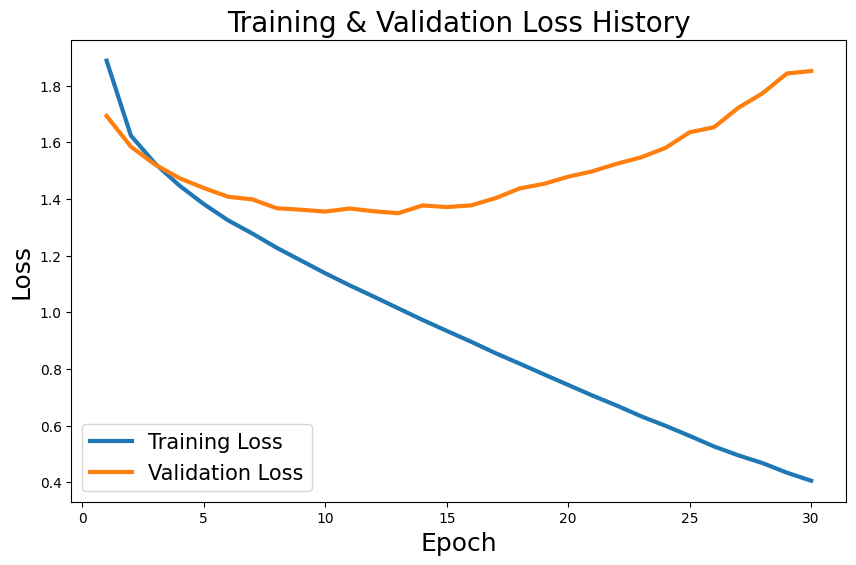

In [21]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Training Loss', linewidth=3)
plt.plot(range(1, len(valid_loss_history) + 1), valid_loss_history, label='Validation Loss', linewidth=3)

plt.title('Training & Validation Loss History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='lower left', fontsize=15)

plt.savefig('figures/cifar_lnn_loss_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

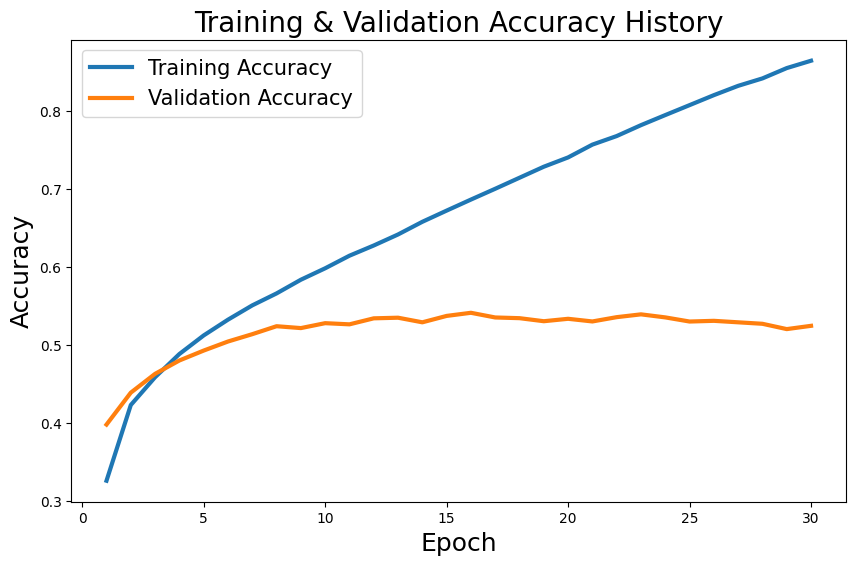

In [22]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_accuracy_history) + 1), train_accuracy_history, label='Training Accuracy', linewidth=3)
plt.plot(range(1, len(valid_accuracy_history) + 1), valid_accuracy_history, label='Validation Accuracy', linewidth=3)

plt.title('Training & Validation Accuracy History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend(loc='upper left', fontsize=15)

plt.savefig('figures/cifar_lnn_accuracy_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

In [23]:
test_loss, test_accuracy = test_model(lnn_model, test_loader, criterion, device='cuda')

Test Loss: 1.8457, Test Accuracy: 0.5220%


#### Convolutional Neural Network

In [24]:
cnn_model = cnn.CNN(3, num_classes=10)

num_params = sum([p.numel() for p in cnn_model.parameters()])
print("Number of parameters: ", num_params)

Number of parameters:  1107538


In [25]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.00001)

train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history = train_model(cnn_model, train_loader, valid_loader, criterion, optimizer, epochs=30, device='cuda', model_name='cnn', dataset_name='cifar')

Epoch 1/30:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/30: 100%|██████████| 157/157 [00:00<00:00, 268.84it/s]


Train Loss: 1.9538, Train Accuracy: 0.3144
Valid Loss: 1.7178, Valid Accuracy: 0.4026


Epoch 2/30: 100%|██████████| 157/157 [00:00<00:00, 267.22it/s]


Train Loss: 1.5969, Train Accuracy: 0.4376
Valid Loss: 1.5104, Valid Accuracy: 0.4624


Epoch 3/30: 100%|██████████| 157/157 [00:00<00:00, 274.70it/s]


Train Loss: 1.4396, Train Accuracy: 0.4868
Valid Loss: 1.4073, Valid Accuracy: 0.4987


Epoch 4/30: 100%|██████████| 157/157 [00:00<00:00, 276.86it/s]


Train Loss: 1.3499, Train Accuracy: 0.5202
Valid Loss: 1.3464, Valid Accuracy: 0.5146


Epoch 5/30: 100%|██████████| 157/157 [00:00<00:00, 258.90it/s]


Train Loss: 1.2916, Train Accuracy: 0.5421
Valid Loss: 1.2989, Valid Accuracy: 0.5365


Epoch 6/30: 100%|██████████| 157/157 [00:00<00:00, 278.79it/s]


Train Loss: 1.2411, Train Accuracy: 0.5613
Valid Loss: 1.2645, Valid Accuracy: 0.5523


Epoch 7/30: 100%|██████████| 157/157 [00:00<00:00, 273.98it/s]


Train Loss: 1.2021, Train Accuracy: 0.5766
Valid Loss: 1.2299, Valid Accuracy: 0.5639


Epoch 8/30: 100%|██████████| 157/157 [00:00<00:00, 261.12it/s]


Train Loss: 1.1678, Train Accuracy: 0.5886
Valid Loss: 1.2003, Valid Accuracy: 0.5780


Epoch 9/30: 100%|██████████| 157/157 [00:00<00:00, 268.34it/s]


Train Loss: 1.1363, Train Accuracy: 0.5986
Valid Loss: 1.1824, Valid Accuracy: 0.5874


Epoch 10/30: 100%|██████████| 157/157 [00:00<00:00, 246.57it/s]


Train Loss: 1.1095, Train Accuracy: 0.6085
Valid Loss: 1.1570, Valid Accuracy: 0.5938


Epoch 11/30: 100%|██████████| 157/157 [00:00<00:00, 274.54it/s]


Train Loss: 1.0846, Train Accuracy: 0.6171
Valid Loss: 1.1417, Valid Accuracy: 0.5979


Epoch 12/30: 100%|██████████| 157/157 [00:00<00:00, 292.45it/s]


Train Loss: 1.0632, Train Accuracy: 0.6269
Valid Loss: 1.1250, Valid Accuracy: 0.6063


Epoch 13/30: 100%|██████████| 157/157 [00:00<00:00, 269.33it/s]


Train Loss: 1.0404, Train Accuracy: 0.6333
Valid Loss: 1.1100, Valid Accuracy: 0.6121


Epoch 14/30: 100%|██████████| 157/157 [00:00<00:00, 283.30it/s]


Train Loss: 1.0194, Train Accuracy: 0.6413
Valid Loss: 1.0983, Valid Accuracy: 0.6178


Epoch 15/30: 100%|██████████| 157/157 [00:00<00:00, 279.96it/s]


Train Loss: 0.9981, Train Accuracy: 0.6494
Valid Loss: 1.0842, Valid Accuracy: 0.6221


Epoch 16/30: 100%|██████████| 157/157 [00:00<00:00, 285.87it/s]


Train Loss: 0.9819, Train Accuracy: 0.6549
Valid Loss: 1.0709, Valid Accuracy: 0.6249


Epoch 17/30: 100%|██████████| 157/157 [00:00<00:00, 258.71it/s]


Train Loss: 0.9641, Train Accuracy: 0.6628
Valid Loss: 1.0640, Valid Accuracy: 0.6324


Epoch 18/30: 100%|██████████| 157/157 [00:00<00:00, 289.81it/s]


Train Loss: 0.9466, Train Accuracy: 0.6695
Valid Loss: 1.0553, Valid Accuracy: 0.6299


Epoch 19/30: 100%|██████████| 157/157 [00:00<00:00, 289.95it/s]


Train Loss: 0.9290, Train Accuracy: 0.6761
Valid Loss: 1.0459, Valid Accuracy: 0.6358


Epoch 20/30: 100%|██████████| 157/157 [00:00<00:00, 301.45it/s]


Train Loss: 0.9140, Train Accuracy: 0.6795
Valid Loss: 1.0360, Valid Accuracy: 0.6379


Epoch 21/30: 100%|██████████| 157/157 [00:00<00:00, 273.00it/s]


Train Loss: 0.9008, Train Accuracy: 0.6855
Valid Loss: 1.0316, Valid Accuracy: 0.6382


Epoch 22/30: 100%|██████████| 157/157 [00:00<00:00, 267.03it/s]


Train Loss: 0.8865, Train Accuracy: 0.6914
Valid Loss: 1.0207, Valid Accuracy: 0.6462


Epoch 23/30: 100%|██████████| 157/157 [00:00<00:00, 271.33it/s]


Train Loss: 0.8719, Train Accuracy: 0.6973
Valid Loss: 1.0132, Valid Accuracy: 0.6455


Epoch 24/30: 100%|██████████| 157/157 [00:00<00:00, 292.59it/s]


Train Loss: 0.8585, Train Accuracy: 0.7017
Valid Loss: 1.0110, Valid Accuracy: 0.6466


Epoch 25/30: 100%|██████████| 157/157 [00:00<00:00, 281.97it/s]


Train Loss: 0.8441, Train Accuracy: 0.7084
Valid Loss: 1.0055, Valid Accuracy: 0.6470


Epoch 26/30: 100%|██████████| 157/157 [00:00<00:00, 297.51it/s]


Train Loss: 0.8324, Train Accuracy: 0.7115
Valid Loss: 0.9974, Valid Accuracy: 0.6539


Epoch 27/30: 100%|██████████| 157/157 [00:00<00:00, 276.13it/s]


Train Loss: 0.8205, Train Accuracy: 0.7160
Valid Loss: 0.9944, Valid Accuracy: 0.6542


Epoch 28/30: 100%|██████████| 157/157 [00:00<00:00, 251.48it/s]


Train Loss: 0.8087, Train Accuracy: 0.7227
Valid Loss: 0.9879, Valid Accuracy: 0.6579


Epoch 29/30: 100%|██████████| 157/157 [00:00<00:00, 273.33it/s]


Train Loss: 0.7956, Train Accuracy: 0.7244
Valid Loss: 0.9828, Valid Accuracy: 0.6576


Epoch 30/30: 100%|██████████| 157/157 [00:00<00:00, 284.44it/s]

Train Loss: 0.7872, Train Accuracy: 0.7278
Valid Loss: 0.9822, Valid Accuracy: 0.6611
Total training time: 99.10 seconds.
Best model at epoch 30 with valid loss: 0.9822, valid accuracy: 0.6611


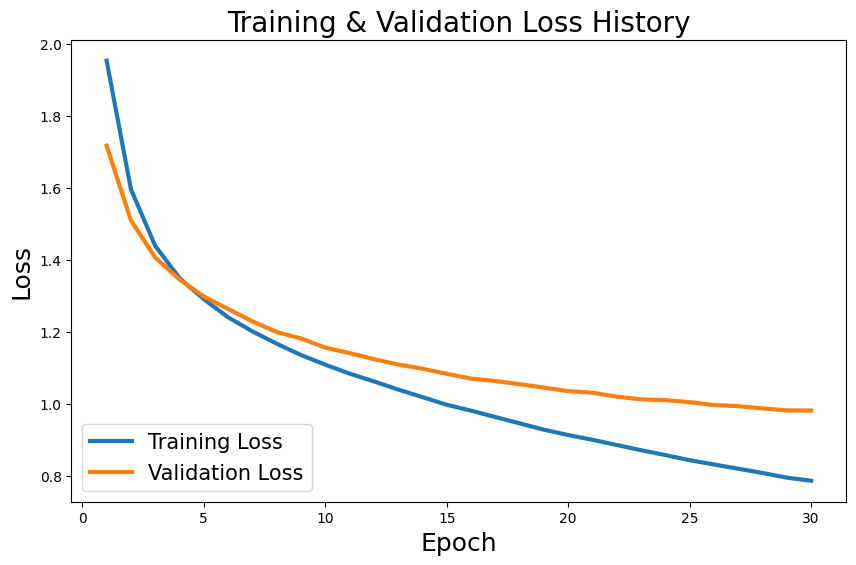

In [26]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Training Loss', linewidth=3)
plt.plot(range(1, len(valid_loss_history) + 1), valid_loss_history, label='Validation Loss', linewidth=3)

plt.title('Training & Validation Loss History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='lower left', fontsize=15)

plt.savefig('figures/cifar_cnn_loss_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

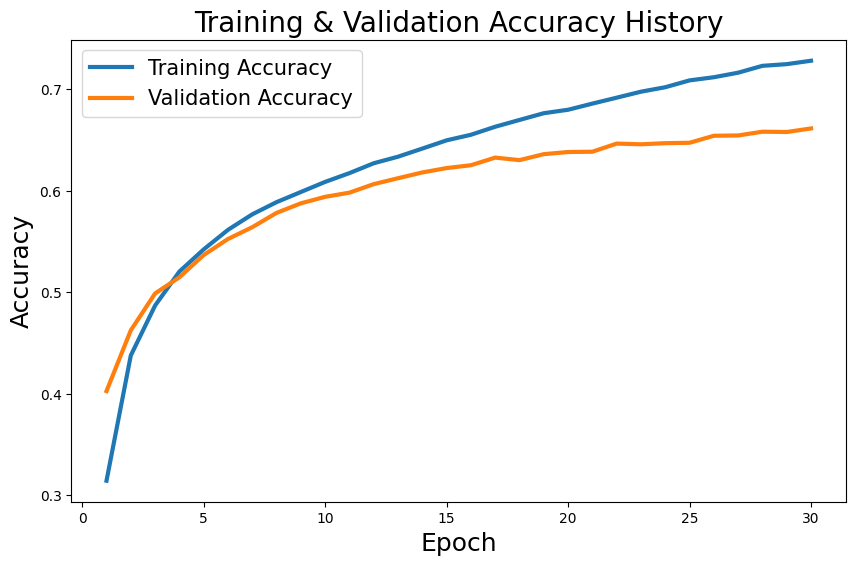

In [27]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_accuracy_history) + 1), train_accuracy_history, label='Training Accuracy', linewidth=3)
plt.plot(range(1, len(valid_accuracy_history) + 1), valid_accuracy_history, label='Validation Accuracy', linewidth=3)

plt.title('Training & Validation Accuracy History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend(loc='upper left', fontsize=15)

plt.savefig('figures/cifar_cnn_accuracy_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

In [28]:
test_loss, test_accuracy = test_model(cnn_model, test_loader, criterion, device='cuda')

Test Loss: 0.9870, Test Accuracy: 0.6512%


### Residual Network

In [29]:
resnet_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [30]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=resnet_transform)
train_set, valid_set = torch.utils.data.random_split(train_dataset, [40000, 10000])
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=resnet_transform)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

In [32]:
resnet_model = resnet.ResNet(num_classes=10, pretrained=True)

num_params = sum([p.numel() for p in resnet_model.parameters()])
print("Number of parameters: ", num_params)

Number of parameters:  11181642


In [33]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.00001)

train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history = train_model(resnet_model, train_loader, valid_loader, criterion, optimizer, epochs=10, device='cuda', model_name='resnet', dataset_name='cifar')

Epoch 1/10: 100%|██████████| 157/157 [00:06<00:00, 24.41it/s]


Train Loss: 0.9170, Train Accuracy: 0.7207
Valid Loss: 0.4193, Valid Accuracy: 0.8757


Epoch 2/10: 100%|██████████| 157/157 [00:06<00:00, 24.47it/s]


Train Loss: 0.3386, Train Accuracy: 0.8989
Valid Loss: 0.2779, Valid Accuracy: 0.9137


Epoch 3/10: 100%|██████████| 157/157 [00:06<00:00, 24.20it/s]


Train Loss: 0.2207, Train Accuracy: 0.9339
Valid Loss: 0.2286, Valid Accuracy: 0.9291


Epoch 4/10: 100%|██████████| 157/157 [00:06<00:00, 23.17it/s]


Train Loss: 0.1541, Train Accuracy: 0.9577
Valid Loss: 0.2042, Valid Accuracy: 0.9368


Epoch 5/10: 100%|██████████| 157/157 [00:06<00:00, 22.98it/s]


Train Loss: 0.1062, Train Accuracy: 0.9740
Valid Loss: 0.1927, Valid Accuracy: 0.9374


Epoch 6/10: 100%|██████████| 157/157 [00:06<00:00, 23.81it/s]


Train Loss: 0.0730, Train Accuracy: 0.9849
Valid Loss: 0.1861, Valid Accuracy: 0.9402


Epoch 7/10: 100%|██████████| 157/157 [00:07<00:00, 19.75it/s]


Train Loss: 0.0471, Train Accuracy: 0.9933
Valid Loss: 0.1844, Valid Accuracy: 0.9399


Epoch 8/10: 100%|██████████| 157/157 [00:08<00:00, 19.40it/s]


Train Loss: 0.0316, Train Accuracy: 0.9970
Valid Loss: 0.1853, Valid Accuracy: 0.9420


Epoch 9/10: 100%|██████████| 157/157 [00:07<00:00, 21.39it/s]


Train Loss: 0.0215, Train Accuracy: 0.9985
Valid Loss: 0.1861, Valid Accuracy: 0.9424


Epoch 10/10: 100%|██████████| 157/157 [00:06<00:00, 22.60it/s]


Train Loss: 0.0151, Train Accuracy: 0.9994
Valid Loss: 0.1858, Valid Accuracy: 0.9427
Total training time: 753.29 seconds.
Best model at epoch 10 with valid loss: 0.1858, valid accuracy: 0.9427


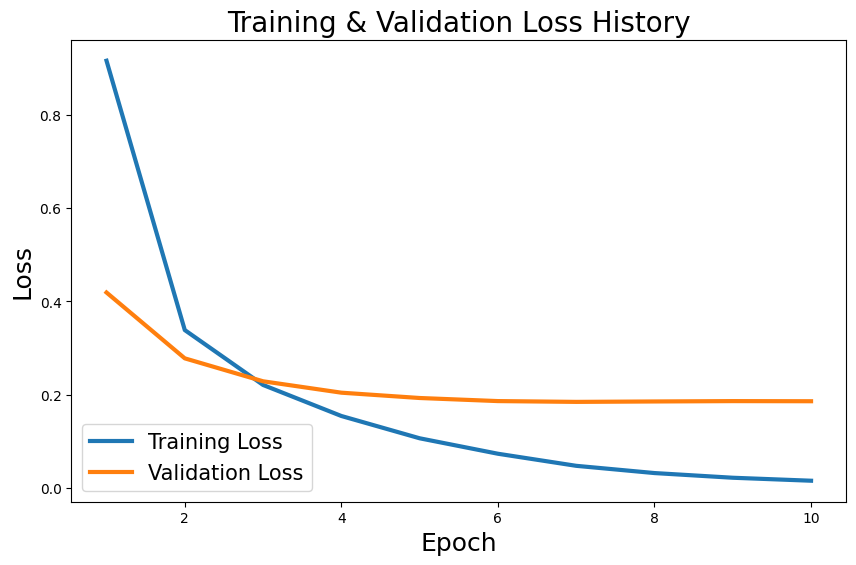

In [34]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Training Loss', linewidth=3)
plt.plot(range(1, len(valid_loss_history) + 1), valid_loss_history, label='Validation Loss', linewidth=3)

plt.title('Training & Validation Loss History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='lower left', fontsize=15)

plt.savefig('figures/cifar_resnet_loss_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

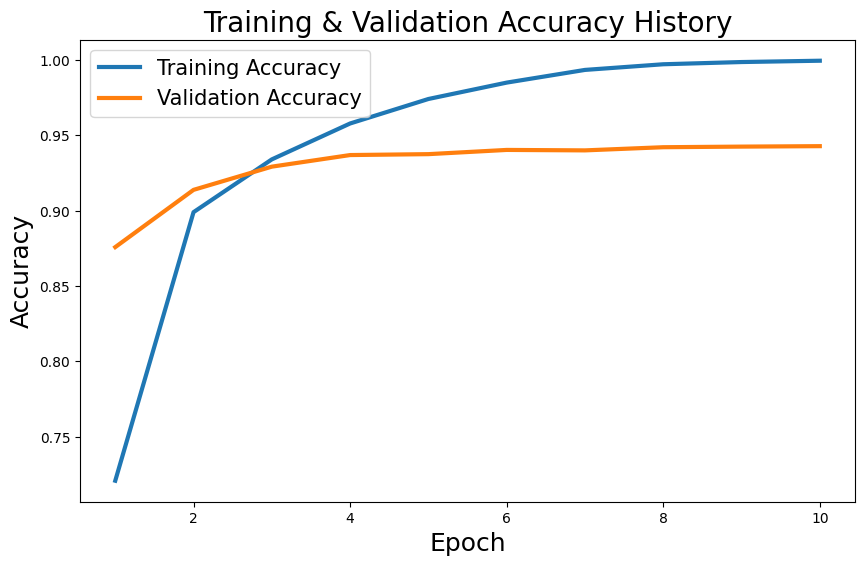

In [35]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_accuracy_history) + 1), train_accuracy_history, label='Training Accuracy', linewidth=3)
plt.plot(range(1, len(valid_accuracy_history) + 1), valid_accuracy_history, label='Validation Accuracy', linewidth=3)

plt.title('Training & Validation Accuracy History', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend(loc='upper left', fontsize=15)

plt.savefig('figures/cifar_resnet_accuracy_history.pdf', format='pdf', bbox_inches='tight')

plt.show();

In [36]:
test_loss, test_accuracy = test_model(resnet_model, test_loader, criterion, device='cuda')

Test Loss: 0.2168, Test Accuracy: 0.9359%
